In [2]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as rnd

# Inversion

Algorithm:
1. Simulate U[0,1]
2. Return $X \leftarrow F^{-1}(U)$

In [30]:
u = np.random.random(size=10000)

In [35]:
def inv_cdf(dist,u,**kwargs):
    match dist:
        case "exponential":
            return -1/kwargs["lam"] * np.log(1-u)
        case "cauchy":
            return kwargs["sigma"] * np.tan(np.pi * (u-0.5))
        case "pareto":
            return kwargs["b"]/(np.power(1-u,1/kwargs['a']))

/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

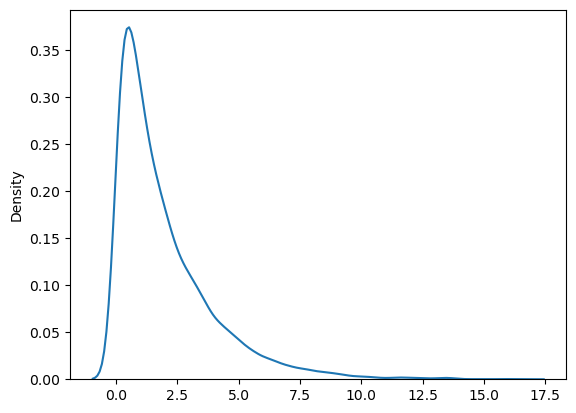

In [34]:
sample = inv_cdf(dist="exponential",u=u,lam=0.5)
sns.kdeplot(sample)

/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

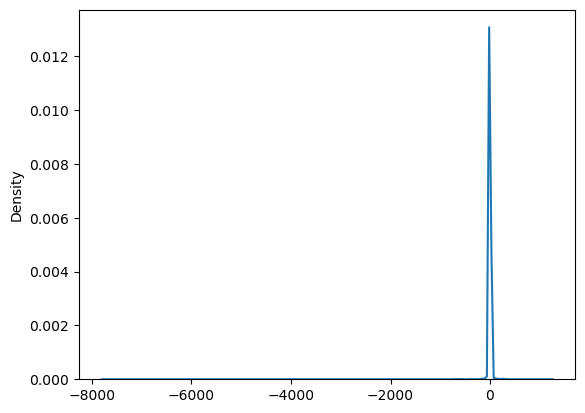

In [33]:
sample = inv_cdf(dist="cauchy",u=u,sigma=1)
sns.kdeplot(sample)

/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

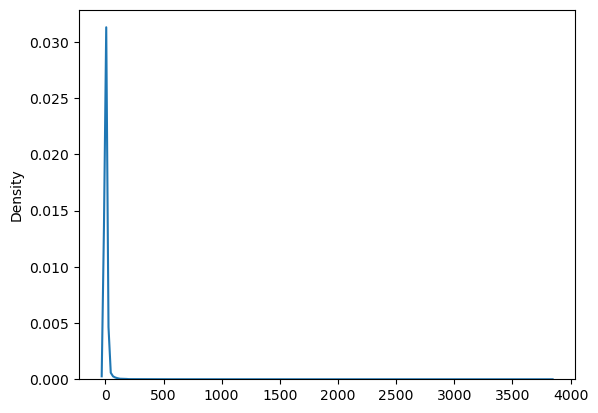

In [36]:
sample = inv_cdf(dist="pareto",u=u,a=1,b=1)
sns.kdeplot(sample)

Generating Maxima/Order Statistics

You can generate maxima using 3 methods:

1. Generate non-uniform sample and take max
2. Generate 1 uniform and invert $F^n$
3. Generate uniform sample, take max, then invert

Order statistics can be generated using order statistics of uniform sample and inverting. 

# Rejection

REPEAT
1. Generate two independent random variates $X$ with density $g$ and $U \sim U[0,1]$
2. Set $T \leftarrow c \frac{g(X)}{f(X)}$

UNTIL $UT \leq 1$

RETURN X

Acceptance probability is $p = P(f(X) \geq cUg(X)) = \frac{1}{c}$

## Example - Normal Distribution

Let $f$ be the standard normal density. Then we have that:

$$\frac{x^2}{2} \geq \frac{1}{2} - |x|$$

Noting that $g(x) = \frac{1}{2}\exp{-|x|}$ is the Laplace density, we can write:

$$f \leq cg(x)$$

where $c=\sqrt{\frac{2e}{\pi}}$

Can simulate Laplace from exponential and uniform, giving:

In [65]:
%%timeit

SAMPLE_SIZE = 1000

X = inv_cdf("exponential",np.random.random(SAMPLE_SIZE),lam=1)
U = np.random.random(SAMPLE_SIZE) * 2 -1

accept_mask = np.power(X-1,2)<=-2*np.log(np.abs(U))

sample = X[accept_mask] * np.sign(U[accept_mask])

83.8 µs ± 1.81 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


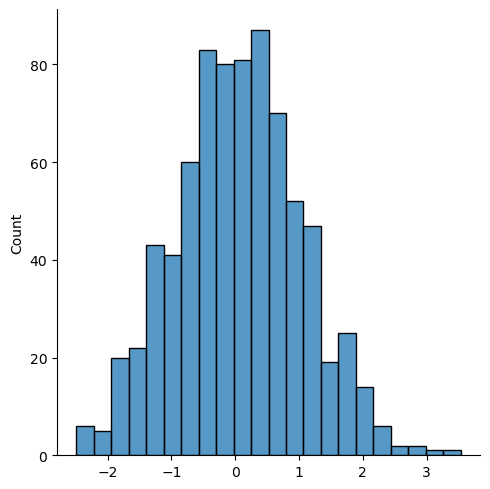

In [57]:
sns.displot(sample)

In [63]:
print(f"sample acceptance prob = {accept_mask.sum() / SAMPLE_SIZE}")
print(f"theoretical acceptance prob = {np.sqrt(np.pi/(2*np.e))}")

sample acceptance prob = 0.767
theoretical acceptance prob = 0.7601734505331404


Or with a cauchy distribution:

In [105]:

%%timeit
SAMPLE_SIZE = 1000

alpha = np.sqrt(np.e) / 2

u = rnd.random(SAMPLE_SIZE)
v = rnd.random(SAMPLE_SIZE)
X = np.tan(np.pi*v)
S = np.square(X)

accept_mask = (u<alpha * (1+S)*np.exp(-S/2))

sample = X[accept_mask]

61.1 µs ± 6.27 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [106]:
sample.shape

(665,)

/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


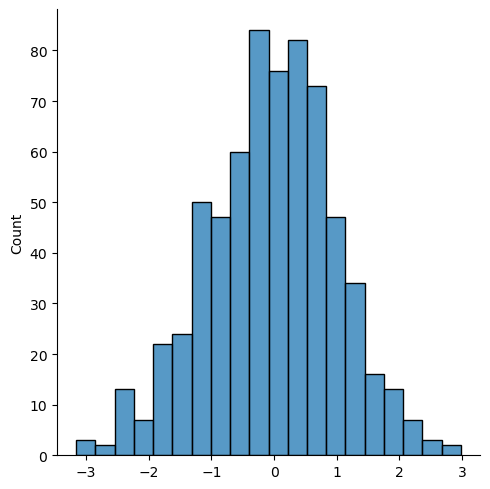

In [107]:
sns.displot(sample)

With Squeeze, by Taylor:

$1 - \frac{x^2}{2} \leq \sqrt{2\pi}f(x) \leq 1 - \frac{x^2}{2} + \frac{x^4}{8}$

In [103]:

%%timeit
SAMPLE_SIZE = 1000

u = rnd.random(SAMPLE_SIZE)
v = rnd.random(SAMPLE_SIZE)
X = np.tan(np.pi*v)
W = 2*u / (np.sqrt(np.e) * (1+X**2))

accept_mask = W <= (1 - X**2/2)

second_accept_mask = ~accept_mask & (W<= np.exp(-X**2/2))

sample = X[accept_mask | second_accept_mask]

64.9 µs ± 604 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


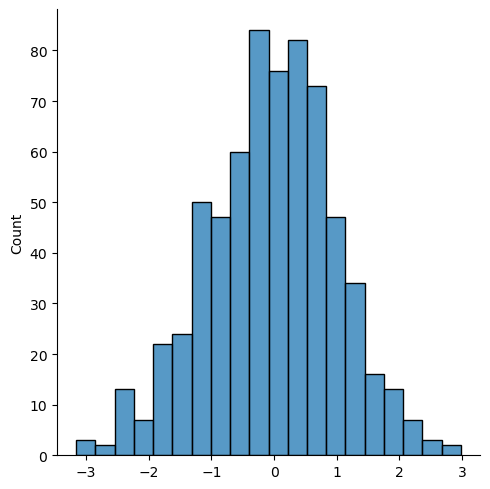

In [102]:
sns.displot(sample)

# Rejection Sampling exercises

## 3.8.1

In [4]:
def normal_density(x,loc,scale):
    return 1/(np.sqrt(2*np.pi)*scale) * np.exp(-0.5*((x-loc)/scale)**2)

In [178]:
sample_size = 10000

n1 = rnd.normal(loc=9,scale=2,size=sample_size)
n2 = rnd.normal(loc=10,scale=4,size=sample_size)

u1 = rnd.random(size=sample_size)

z = np.where(u1>0.5,n1,n2)

u2 = rnd.random(size=sample_size)

sample = z[(np.max([normal_density(z,1,2),normal_density(z,10,4)],axis=0)/np.sum([normal_density(z,1,2),normal_density(z,10,4)],axis=0))>=u2]

sample.shape

(9652,)

/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

<Axes: ylabel='Density'>

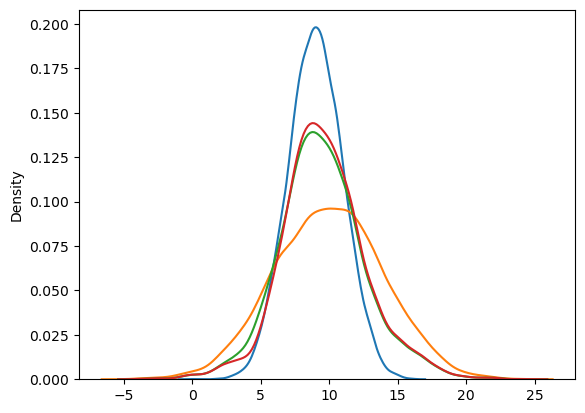

In [179]:
fig,axs=plt.subplots()
sns.kdeplot(n1,ax=axs)
sns.kdeplot(n2,ax=axs)
sns.kdeplot(z,ax=axs)
sns.kdeplot(sample,ax=axs)

In [8]:
sample_size = 10000

n1 = rnd.normal(loc=4,scale=2,size=sample_size)
n2 = rnd.normal(loc=10,scale=4,size=sample_size)

u1 = rnd.random(size=sample_size)

z = np.where(u1>0.5,n1,n2)

u2 = rnd.random(size=sample_size)

sample = z[(np.min([normal_density(z,1,2),normal_density(z,10,4)],axis=0)/(np.sum([normal_density(z,1,2),normal_density(z,10,4)],axis=0)/2))>=u2]

sample.shape

(2367,)

/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

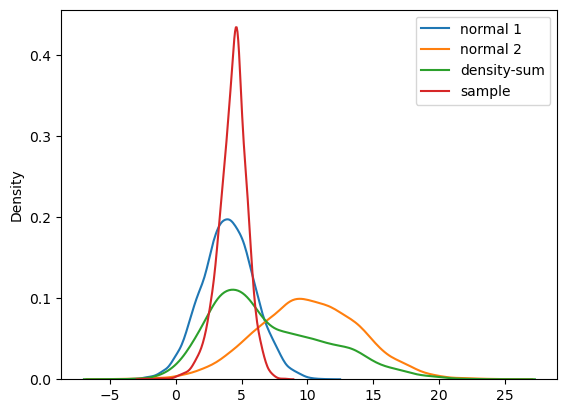

In [9]:
fig,axs=plt.subplots()
sns.kdeplot(n1,ax=axs,legend=True,label="normal 1")
sns.kdeplot(n2,ax=axs,label="normal 2")
sns.kdeplot(z,ax=axs, label="density-sum")
sns.kdeplot(sample,ax=axs,label='sample')
plt.legend()